# Zonotope Analysis Part 1
In commit `3e70619` we have implemented a working version of Zonotope propagation without refinement.
The current version (still?) uses LP solving on every split in order to avoid an explosion of Zonotopes.

Questions we are interested in:
- At what depth do we show equivalence/at what depth does the Zonotope become infeasible?
- How precise is the equivalence we show? For how many cases do we need refinement?

In [11]:
import parse
import matplotlib.pyplot as plt
import numpy as np

In [18]:
acas_1_1 = parse.BenchmarkRun("../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3e70619/stdout.log","../results/ACASXU_run2a_1_1_batch_2000-trunc/1/nnequiv-3e70619/stderr.log")
acas_1_2 = parse.BenchmarkRun("../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3e70619/stdout.log","../results/ACASXU_run2a_1_2_batch_2000-trunc/1/nnequiv-3e70619/stderr.log")
har = parse.BenchmarkRun("../results/HAR-trunc/1/nnequiv-21af8ae/stdout.log","../results/HAR-trunc/1/nnequiv-21af8ae/stderr.log")

## Decision Depth Histogram

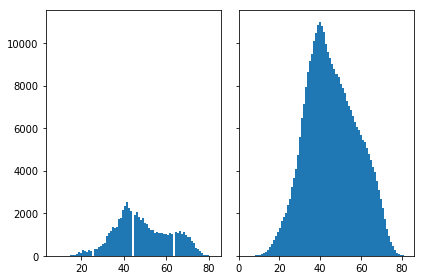

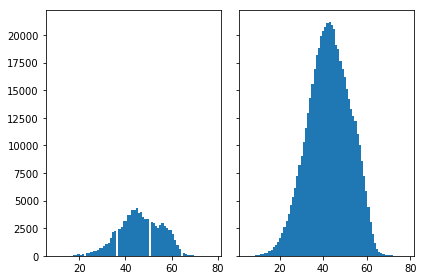

In [19]:
%matplotlib inline
def plot_depth_hist(run):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    max_val = max(max(run.depth.valid_depth),max(run.depth.invalid_depth))
    min_val = min(min(run.depth.valid_depth),min(run.depth.invalid_depth))
    n_bins = max_val-min_val+1

    # We can set the number of bins with the `bins` kwarg
    return (axs[0].hist(run.depth.valid_depth, bins=n_bins),
    axs[1].hist(run.depth.invalid_depth, bins=n_bins))

depth_hists_1_1=plot_depth_hist(acas_1_1)
depth_hists_1_2=plot_depth_hist(acas_1_2)

## Shown (Non-)Equivalence

Non Equivalent: 0
Non Equivalent: 0
Non Equivalent: 8880
Max: 1.6747442483901978


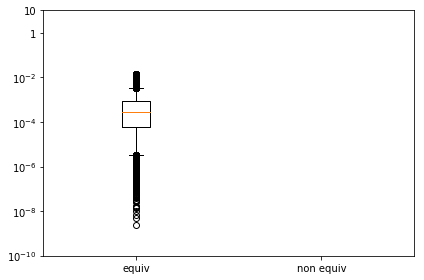

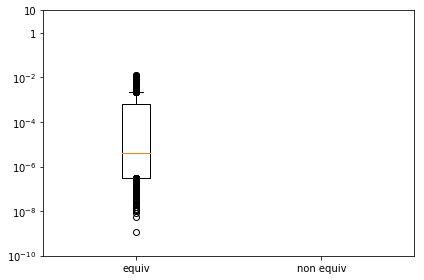

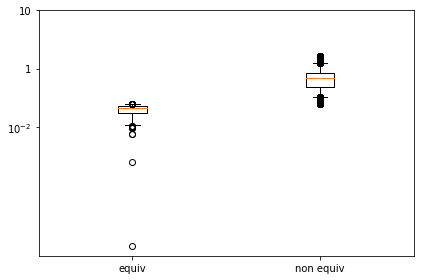

In [26]:
%matplotlib inline
def plot_equiv_hist(run,ticks=(1,0, -2,-4,-6,-8,-10),labels=("10","1","$10^{-2}$","$10^{-4}$","$10^{-6}$","$10^{-8}$","$10^{-10}$")):
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    n_bins =80
    print(f"Non Equivalent: {len(run.equiv.nonequiv)}")
    if len(run.equiv.nonequiv)>0:
        print(f"Max: {max(run.equiv.nonequiv)}")
    # We can set the number of bins with the `bins` kwarg
    #return (axs[0].hist(run.equiv.equiv, bins=n_bins),
    #axs[1].hist(run.equiv.nonequiv, bins=n_bins))
    plt.boxplot([np.log10(run.equiv.equiv), np.log10(np.array(run.equiv.nonequiv))],whis=(5,95))
    plt.xticks(ticks=(1,2),labels=("equiv", "non equiv"))
    plt.yticks(ticks=ticks,labels=labels)

equiv_hists_1_1=plot_equiv_hist(acas_1_1)
equiv_hists_1_2=plot_equiv_hist(acas_1_2)
equiv_hists_har=plot_equiv_hist(har,ticks=[1,0,-1])